In [1]:
import os
import random
import datetime

import numpy as np
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from model import transform, predict, CNNModel, ViTModel
from mydataset import split_dataset

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
BATCH_SIZE = 24
TR_RATIO = 0.8
train_dataset, dev_dataset, train_loader, dev_loader = split_dataset(16, TR_RATIO)
train_size = len(train_dataset)

dataset size 577
tr size 461 dev size 116


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


样本[342]: torch.Size([3, 224, 224]), 标签: 1


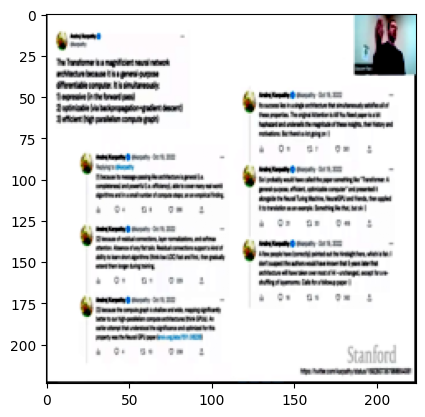

In [3]:
idx = np.random.randint(0, train_size)
img, lbl = train_dataset[idx]
print(f"样本[{idx}]: {img.shape}, 标签: {lbl}")  # 输出: 样本: torch.Size([3, 224, 224]), 标签: 1 (正例)

plt.imshow(img.permute(1, 2, 0));

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTModel().to(DEVICE)

params_total = sum(p.numel() for p in model.parameters())
print('parameters', f'{params_total:,}', f"{params_total / 1e9:.2f}B")

/Users/huanghao/miniconda3/envs/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/huanghao/miniconda3/envs/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


parameters 85,800,194 0.09B


In [5]:
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

running_loss, running_dev_loss = [], []
running_acc, running_dev_acc = [], []

def train(epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0  # 记录训练分类准确率
        tqdm_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
        for images, labels in tqdm_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
    
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
            total_loss += loss.item()
    
            # 计算分类准确率
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            running_loss.append(loss.item())
            running_acc.append(correct / total)
    
            tqdm_bar.set_postfix(loss=loss.item(), acc=f"{correct/total:.4f}")
    
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {correct/total:.4f}")
        if correct/total > .95:
            model_filename = f"slide_classifier_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{epoch+1:03d}.pth"
            torch.save(model.state_dict(), model_filename)
            print("✅ 保存模型", model_filename)

        fig = plt.figure()
        plt.plot(running_loss, label='tr loss')
        plt.legend()
        fig = plt.figure()
        plt.plot(running_acc, label='tr acc')
        plt.legend()
        plt.show()

        # ✅ 验证阶段
        model.eval()
        dev_loss, dev_correct, dev_total = 0, 0, 0
        with torch.no_grad():
            for images, labels in dev_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
    
                outputs = model(images)
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
    
                preds = torch.argmax(outputs, dim=1)
                dev_correct += (preds == labels).sum().item()
                dev_total += labels.size(0)
    
        dev_acc = dev_correct / dev_total
        print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {dev_loss/dev_total:.4f}, Validation Accuracy: {dev_acc:.4f}")

Epoch 1/10: 100%|████████████████████████| 29/29 [01:15<00:00,  2.60s/it, acc=0.7050, loss=0.779]

Epoch [1/10], Train Loss: 0.9990, Train Acc: 0.7050


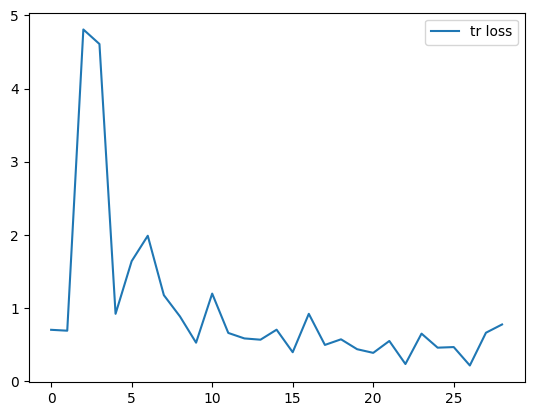

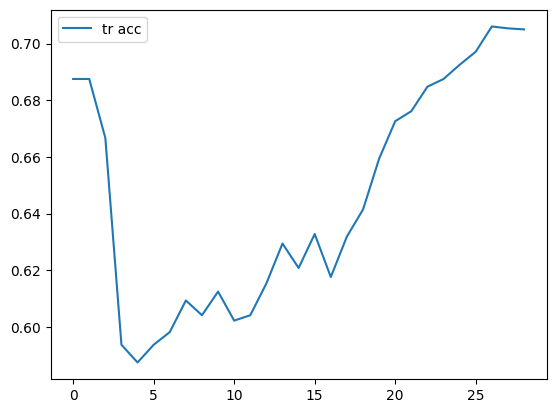

Epoch [1/10], Validation Loss: 0.0421, Validation Accuracy: 0.7328


Epoch 2/10: 100%|████████████████████████| 29/29 [01:09<00:00,  2.41s/it, acc=0.8330, loss=0.451]

Epoch [2/10], Train Loss: 0.4565, Train Acc: 0.8330


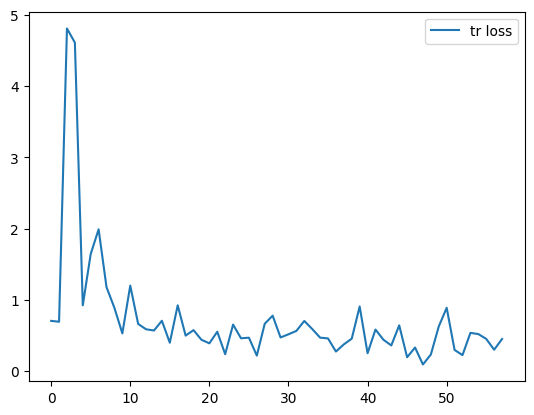

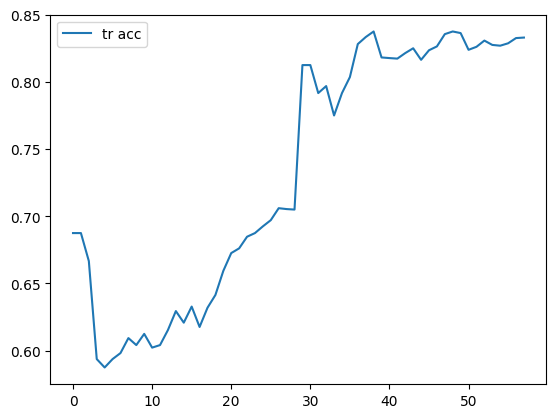

Epoch [2/10], Validation Loss: 0.0378, Validation Accuracy: 0.8017


Epoch 3/10: 100%|████████████████████████| 29/29 [01:15<00:00,  2.60s/it, acc=0.8720, loss=0.732]

Epoch [3/10], Train Loss: 0.3989, Train Acc: 0.8720


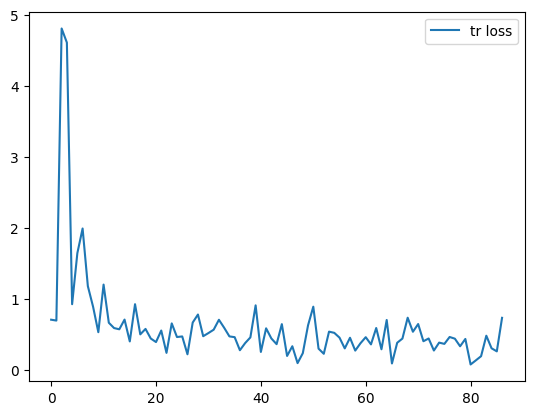

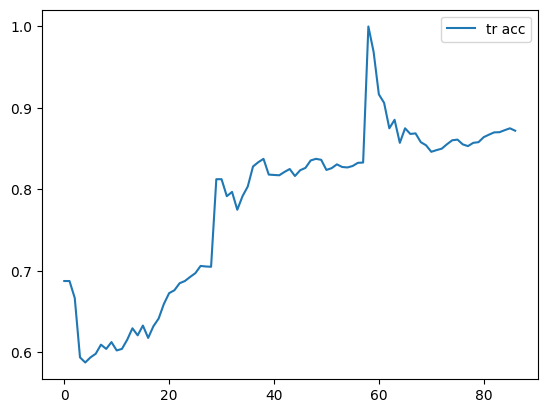

Epoch [3/10], Validation Loss: 0.0391, Validation Accuracy: 0.8103


Epoch 4/10: 100%|███████████████████████| 29/29 [01:08<00:00,  2.37s/it, acc=0.8698, loss=0.0629]

Epoch [4/10], Train Loss: 0.3721, Train Acc: 0.8698


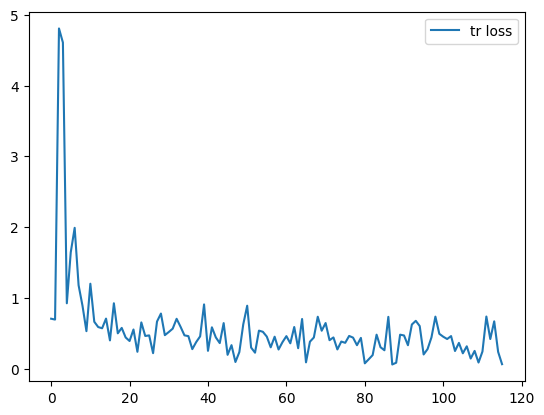

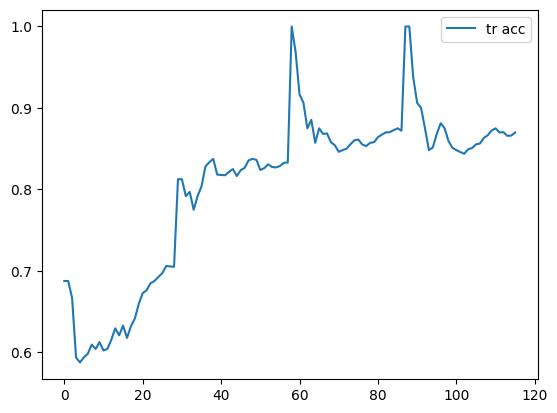

Epoch [4/10], Validation Loss: 0.0377, Validation Accuracy: 0.8276


Epoch 5/10: 100%|████████████████████████| 29/29 [01:08<00:00,  2.37s/it, acc=0.8568, loss=0.125]

Epoch [5/10], Train Loss: 0.3642, Train Acc: 0.8568


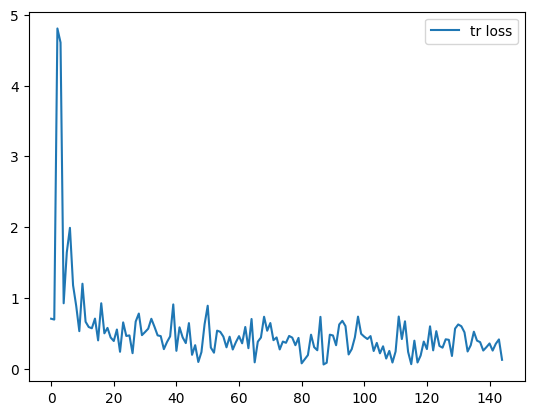

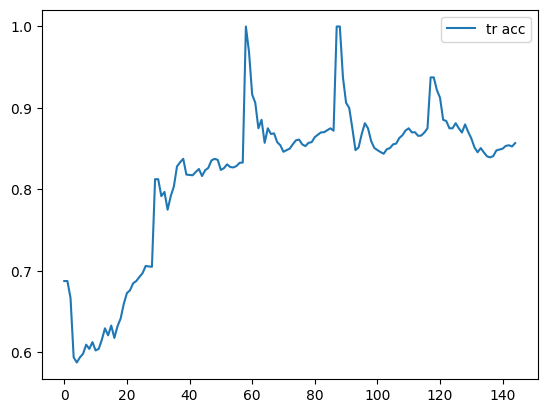

Epoch [5/10], Validation Loss: 0.0367, Validation Accuracy: 0.8017


Epoch 6/10: 100%|████████████████████████| 29/29 [01:08<00:00,  2.37s/it, acc=0.8698, loss=0.644]

Epoch [6/10], Train Loss: 0.3652, Train Acc: 0.8698


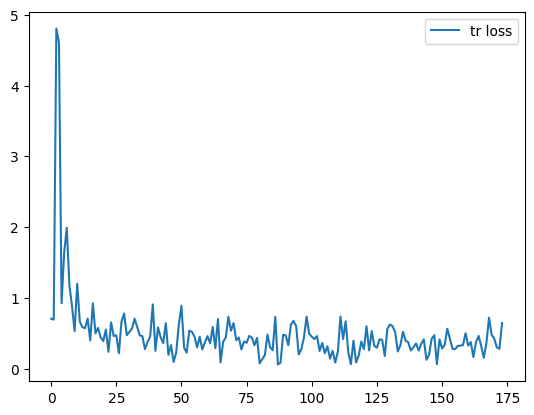

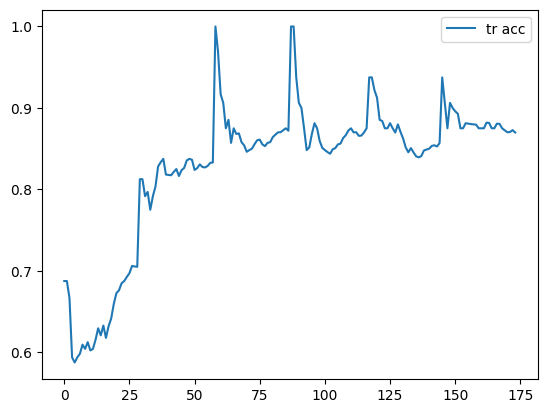

Epoch [6/10], Validation Loss: 0.0328, Validation Accuracy: 0.8276


Epoch 7/10: 100%|█████████████████████████| 29/29 [01:08<00:00,  2.37s/it, acc=0.8568, loss=0.26]

Epoch [7/10], Train Loss: 0.3710, Train Acc: 0.8568


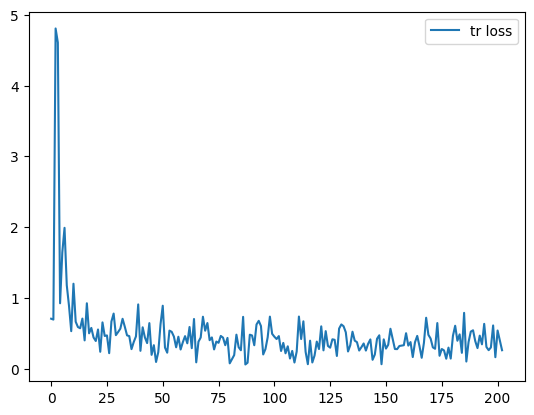

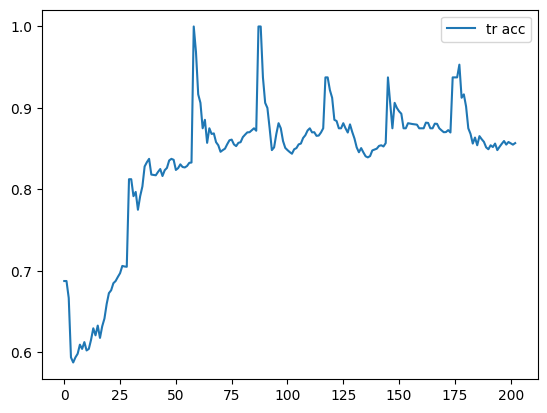

Epoch [7/10], Validation Loss: 0.0362, Validation Accuracy: 0.7931


Epoch 8/10: 100%|█████████████████████████| 29/29 [01:09<00:00,  2.40s/it, acc=0.7722, loss=0.53]

Epoch [8/10], Train Loss: 0.5270, Train Acc: 0.7722


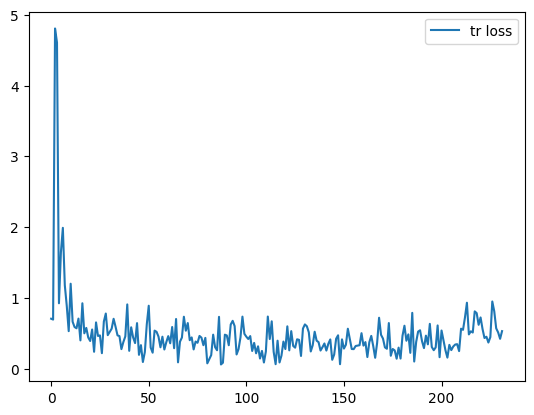

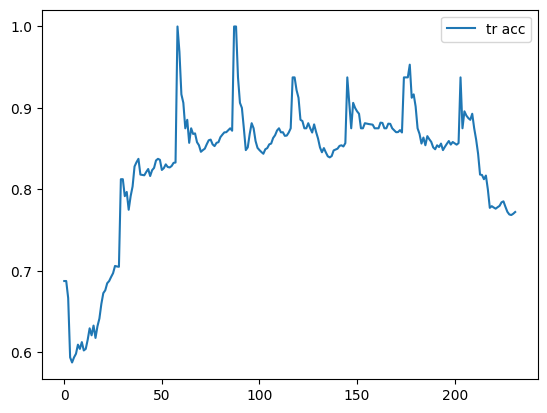

Epoch [8/10], Validation Loss: 0.0455, Validation Accuracy: 0.6379


Epoch 9/10: 100%|████████████████████████| 29/29 [01:09<00:00,  2.39s/it, acc=0.8178, loss=0.371]

Epoch [9/10], Train Loss: 0.4589, Train Acc: 0.8178


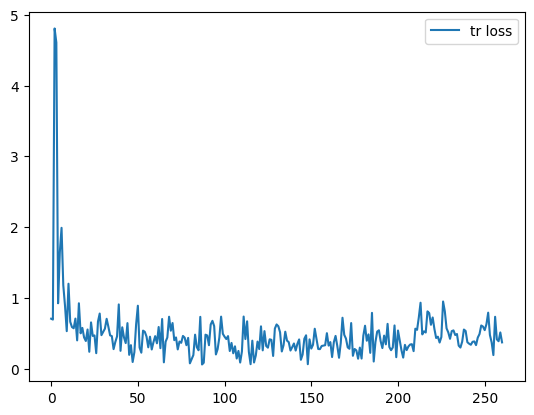

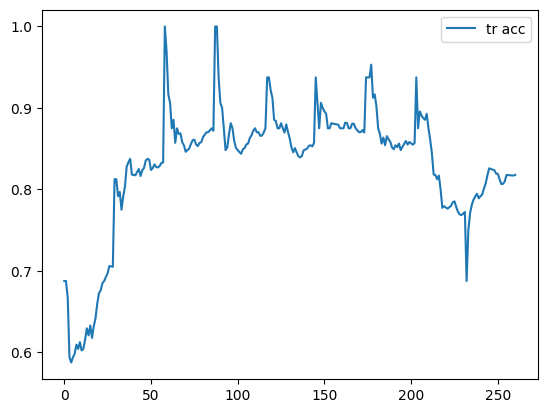

Epoch [9/10], Validation Loss: 0.0442, Validation Accuracy: 0.8017


Epoch 10/10: 100%|███████████████████████| 29/29 [01:14<00:00,  2.56s/it, acc=0.8503, loss=0.282]

Epoch [10/10], Train Loss: 0.4107, Train Acc: 0.8503


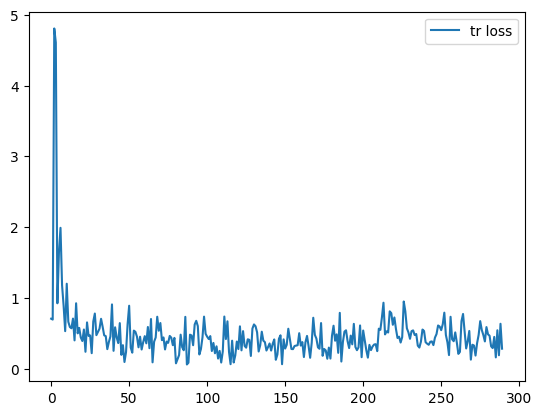

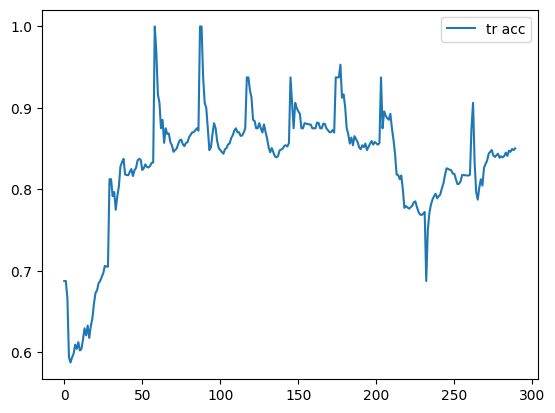

Epoch [10/10], Validation Loss: 0.0357, Validation Accuracy: 0.8017


In [6]:
train(10)

In [53]:

def load_labeled_images():
    """ 读取正例和负例文件，返回两个列表 """
    positive_images, negative_images = set(), set()
    
    if os.path.exists(POSITIVE_LABEL_FILE):
        with open(POSITIVE_LABEL_FILE, "r") as f:
            positive_images = set(line.strip() for line in f)
    
    if os.path.exists(NEGATIVE_LABEL_FILE):
        with open(NEGATIVE_LABEL_FILE, "r") as f:
            negative_images = set(line.strip() for line in f)

    return list(positive_images), list(negative_images)


def get_all_images(base_dir):
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp", ".gif")
    images = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(image_extensions):
                rel_path = os.path.relpath(os.path.join(root, file), base_dir)
                images.append(rel_path)
    return sorted(images)

all_images = get_all_images(IMAGE_BASE_PATH)
positive_images, negative_images = load_labeled_images()
labeled_images = set(positive_images + negative_images)
filtered_images = [img for img in all_images if img not in labeled_images]
len(all_images), len(labeled_images), len(filtered_images)

(403, 385, 18)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1 预测结果: 正例
1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47450978..0.94509804].


1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.92941177].


0 预测结果: 负例
0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.52156866].


0 预测结果: 负例
0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46666664..0.9607843].


1 预测结果: 正例
1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4980392..0.9843137].


1 预测结果: 正例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29411763..0.9529412].


0 预测结果: 负例


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


0 预测结果: 负例


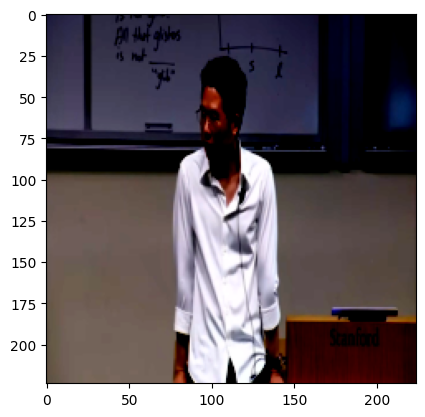

In [61]:
# ✅ 预测新图片
samples = random.sample(filtered_images, BATCH_SIZE)
for img_path in samples:
    img_path = os.path.join(IMAGE_BASE_PATH, img_path)
    img, label = predict(img_path, model, transform, DEVICE)
    img = img.squeeze(0)
    plt.imshow(img.permute(1, 2, 0))
    print(label, f"预测结果: {'正例' if label == 1 else '负例'}")
    
#image_path = "test_image.jpg"
#label = predict_image(image_path, model, transform, device)
#print(f"预测结果: {'正例' if label == 1 else '负例'}")